In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from copy import deepcopy

In [2]:
STAY = 0
LEFT = 1
UP = 2
RIGHT = 3
DOWN = 4

In [3]:
class GridWorld(object):
    
    def __init__(self, reward_array, noise_array = None):
        # reward_array is x_size * y_size * 5
        self.reward_array = reward_array
        self.x_size = reward_array.shape[0]
        self.y_size = reward_array.shape[1]
        assert reward_array.shape[2] == 5
        
        if noise_array is None:
            noise_array = np.zeros_like(reward_array)
        self.noise_array = noise_array
        assert noise_array.shape == reward_array.shape
        
        self.avail_actions = np.zeros((x_size, y_size, 5))
        for x in range(self.x_size):
            for y in range(self.y_size):
                self.avail_actions[x,y,STAY] = 1
                self.avail_actions[x,y,LEFT] = int(x != 0)
                self.avail_actions[x,y,RIGHT] = int(x != self.x_size - 1)
                self.avail_actions[x,y,DOWN] = int(y != 0)
                self.avail_actions[x,y,UP] = int(y != self.y_size - 1)
                
            
    def reset(self):
        #self.state = [self.x_size // 2, self.y_size // 2]
        x = np.random.choice(self.x_size)
        y = np.random.choice(self.y_size)
        self.state = [x, y]
        return deepcopy(self.state)
        
    def seed(self, seed):
        np.random.seed(seed)
            
    def step(self, action):
        assert self.avail_actions[self.state[0], self.state[1], action] == 1
        
        reward = np.random.normal(self.reward_array[self.state[0], self.state[1], action],
                                      self.noise_array[self.state[0], self.state[1], action])
        
        if action == LEFT:
            self.state[0] -= 1
        elif action == RIGHT:
            self.state[0] += 1
        elif action == UP:
            self.state[1] += 1
        elif action == DOWN:
            self.state[1] -= 1   
            
        return deepcopy(self.state), reward
        
        
    def render(self):
        uniform = self.avail_actions / np.sum(self.avail_actions, axis=2, keepdims=True)
        plt.imshow(np.sum(uniform*self.reward_array, axis = 2).transpose(), origin='lower')
        plt.colorbar()
        plt.show()

In [4]:
def collect_data(mdp, pi, n_traj, ep_len):
    dataset = []
    for n in range(n_traj):
        state = mdp.reset()
        for t in range(ep_len):
            action = np.random.choice([0,1,2,3,4], p=pi[state[0], state[1]])
            next_state, reward = mdp.step(action) 
            dataset.append([state[0], state[1], action, reward])
            state = next_state
    return np.array(dataset)

def empirical_mdp(data, mdp):
    emp_reward = np.zeros_like(mdp.reward_array)
    sa_counts = np.zeros_like(mdp.reward_array)

    for i in range(len(data)):
        d = data[i]
        x, y, a, r = int(d[0]), int(d[1]), int(d[2]), d[3]
        sa_counts[x,y,a] += 1
        emp_reward[x,y,a] += r

    emp_reward /= (sa_counts + 1e-8)

    emp_grid = GridWorld(emp_reward)
    return emp_grid

In [5]:
def render_Q(Q, policy, show_greedy=True, show_all_actions=False):
    plt.imshow(np.sum(Q*policy, axis = 2).transpose(), origin='lower')
    plt.colorbar()
    
    if show_greedy:
        for x in range(Q.shape[0]):
            for y in range(Q.shape[1]):
                greedy_action = np.argmax(Q[x,y])
                if greedy_action == RIGHT:
                    plt.arrow(x, y, 0.3, 0, color='white', head_width=0.2)
                elif greedy_action == LEFT:
                    plt.arrow(x, y, -0.3, 0, color='white', head_width=0.2)
                elif greedy_action == DOWN:
                    plt.arrow(x, y, 0, -0.3, color='white', head_width=0.2)
                elif greedy_action == UP:
                    plt.arrow(x, y, 0, 0.3, color='white', head_width=0.2)
#                 elif greedy_action == STAY:
#                     plt.scatter(x, y, color='white',marker='o',s=100)
    
    elif show_all_actions:
        for x in range(Q.shape[0]):
            for y in range(Q.shape[1]):
                probs = policy[x,y]
                if probs[RIGHT] > 0:
                    plt.arrow(x, y, 0.2, 0, color='white', head_width=probs[RIGHT]/2)
                if probs[LEFT] > 0:
                    plt.arrow(x, y, -0.2, 0, color='white', head_width=probs[LEFT]/2)
                if probs[DOWN] > 0:
                    plt.arrow(x, y, 0, -0.2, color='white', head_width=probs[DOWN]/2)
                if probs[UP] > 0:
                    plt.arrow(x, y, 0, 0.2, color='white', head_width=probs[UP]/2)
#                 if probs[STAY] > 0:
#                     plt.scatter(x, y, color='white',marker='o',s=probs[STAY]*200)
    plt.show()

In [6]:
def render_Q_ax(ax, Q, policy, show_actions=True, vmin=None, vmax=None):
    im = ax.imshow(np.sum(Q*policy, axis = 2).transpose(), origin='lower', vmin=vmin, vmax=vmax)
    
    if show_actions:
        for x in range(Q.shape[0]):
            for y in range(Q.shape[1]):
                probs = policy[x,y]
                if probs[RIGHT] > 0:
                    ax.arrow(x, y, 0.2, 0, color='white', head_width=probs[RIGHT]/2)
                if probs[LEFT] > 0:
                    ax.arrow(x, y, -0.2, 0, color='white', head_width=probs[LEFT]/2)
                if probs[DOWN] > 0:
                    ax.arrow(x, y, 0, -0.2, color='white', head_width=probs[DOWN]/2)
                if probs[UP] > 0:
                    ax.arrow(x, y, 0, 0.2, color='white', head_width=probs[UP]/2)
#                 if probs[STAY] > 0:
#                     plt.scatter(x, y, color='white',marker='o',s=probs[STAY]*200)

    return im

In [7]:
def render_action(arr, action):
    plt.imshow((arr[:,:,action]).transpose(), origin='lower')
    plt.colorbar()
    plt.show()

In [8]:
# Q is x_size * y_size * 5
# pi is x_size * y_size * 5
# pi must only put mass on available actions
def value_estimation(grid, pi, init_Q, iters, gamma):
    Q = init_Q
    assert Q.shape == grid.reward_array.shape
    assert np.sum(np.abs(pi * (grid.avail_actions -1) )) == 0
    assert np.sum(np.abs(np.sum(pi, axis=2) - 1)) < 1e-6
    
    for it in range(iters):
        newQ = np.zeros_like(Q)
        V = np.sum(pi*Q, axis = 2)
        newQ[:, :, STAY] = grid.reward_array[:, :, STAY] + gamma * V[:, :]
        
        newQ[1:, :, LEFT] = grid.reward_array[1:, :, LEFT] + gamma * V[:-1, :]
        newQ[:-1, :, RIGHT] = grid.reward_array[:-1, :, RIGHT] + gamma * V[1:, :]
        newQ[:, :-1, UP] = grid.reward_array[:, :-1, UP] + gamma * V[:, 1:]
        newQ[:, 1:, DOWN] = grid.reward_array[:, 1:, DOWN] + gamma * V[:, :-1]
        
        Q = newQ
    
    return Q

In [9]:
def get_greedy_policy(Q, avail_actions):
    pos_Q = avail_actions * (Q - np.min(Q) + 1)
    pi = np.zeros_like(pos_Q)
    max_idx = np.argmax(pos_Q, axis=2)
    for x in range(pi.shape[0]):
        for y in range(pi.shape[1]):
            pi[x,y,max_idx[x,y]] = 1
    return pi

In [10]:
def get_exp_policy(beta, Q, temp):
    exp_pi = beta * np.exp(temp * Q)
    for x in range(Q.shape[0]):
        for y in range(Q.shape[1]):
            exp_pi[x,y] =  exp_pi[x,y] / np.sum(exp_pi[x,y])
    return exp_pi

In [11]:
def get_value(Q, pi):
    return np.mean(np.sum(Q * pi, axis = -1))

# Finite data

In [29]:
x_size = 15
y_size = 15
r = np.zeros((x_size,y_size,5))
r[-1, -1, :] = 1

r[0, :, :] = -0.5
r[:, 0, :] = -0.5

sigma = np.zeros((x_size,y_size,5))
sigma[0, :, :] =  1.0
sigma[:, 0, :] =  1.0


# r[:-7, -1, :] = -0.5
# r[-1, :-7, :] = -0.5
# sigma[:-7, -1, :] = 1.0
# sigma[-1, :-7, :] = 1.0

grid = GridWorld(r,  sigma)

# uniform beta
avail = grid.avail_actions
uniform = avail / np.sum(avail, axis=2, keepdims=True)

# non-uniform beta
biased_pi = np.zeros_like(uniform)

# optimal
biased_pi[:-1, :-1, RIGHT] = 0.5
biased_pi[:-1, :-1, UP] = 0.5
biased_pi[-1, :-1, UP] = 1.0
biased_pi[:-1, -1, RIGHT] = 1.0
biased_pi[-1, -1, STAY] = 1.0


mix = 0.2
beta = mix * biased_pi + (1.0 - mix) * uniform

np.random.seed(3)
data = collect_data(grid, beta, 100, 100)
emp_grid = empirical_mdp(data, grid)

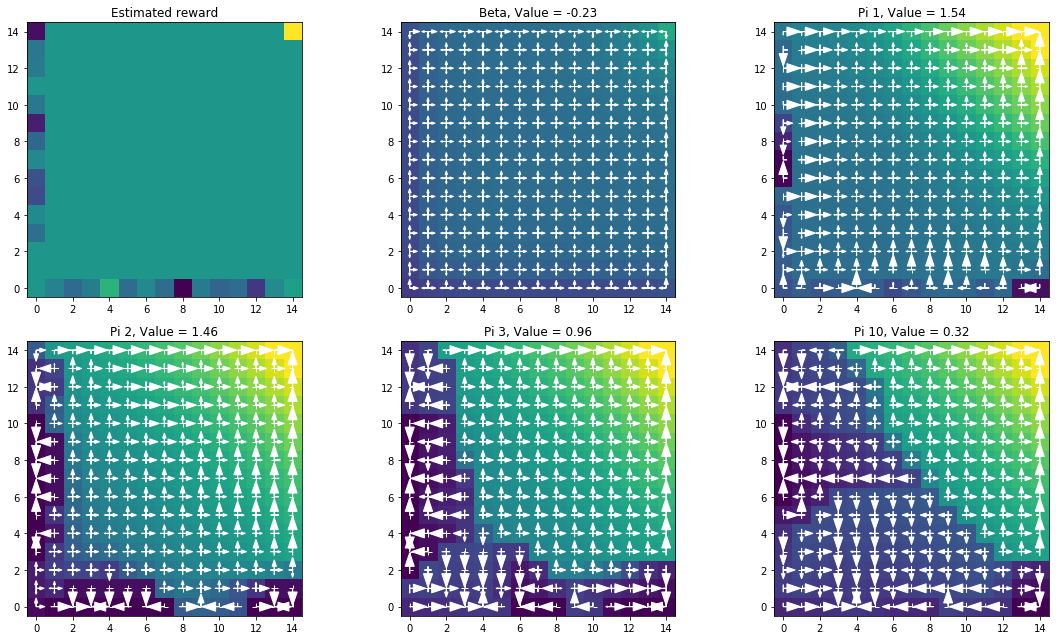

In [30]:
temp = 10.0
discount = 0.9


fig, ax = plt.subplots(2, 3)
fig.set_size_inches(16, 9)

render_Q_ax(ax[0,0], emp_grid.reward_array, beta, show_actions=False)
ax[0,0].set_title('Estimated reward')

init_Q = emp_grid.reward_array
Q = value_estimation(emp_grid, beta, init_Q, iters=100, gamma=discount)
Q_true = value_estimation(grid, beta, grid.reward_array, iters=100, gamma=discount)

render_Q_ax(ax[0,1], Q_true, beta, vmin=-5, vmax=9)
ax[0,1].set_title('Beta, Value = ' + "{:.2f}".format(get_value(Q_true, beta)))

pis = [beta]

for i in range(1,11):

    pi = get_exp_policy(beta, Q, temp)
    pis.append(pi)
    init_Q = emp_grid.reward_array
    Q = value_estimation(emp_grid, pi, init_Q, iters=100, gamma=discount)
    Q_true = value_estimation(grid, pi, grid.reward_array, iters=100, gamma=discount)
    
    if i == 1:
        render_Q_ax(ax[0,2], Q_true, pi, vmin=-5, vmax=9)
        ax[0,2].set_title('Pi ' + str(i) + ', Value = ' + "{:.2f}".format(get_value(Q_true, pi)))
    
    elif i <= 3 or i == 10:
        idx = min(i-2, 2)
        render_Q_ax(ax[1,idx], Q_true, pi, vmin=-5, vmax=9)
        ax[1,idx].set_title('Pi ' + str(i) + ', Value = ' + "{:.2f}".format(get_value(Q_true, pi)))
        
plt.tight_layout()
plt.savefig('gridworld_onestep.png', dpi=300)
plt.show()

In [31]:
error_grid = GridWorld(emp_grid.reward_array - grid.reward_array)

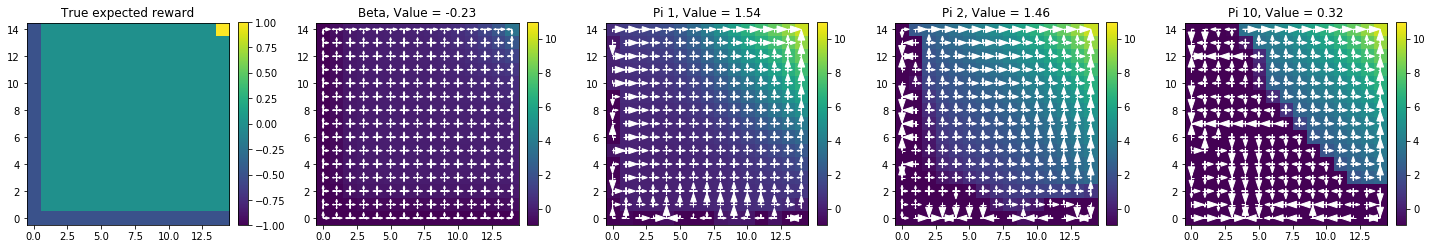

In [32]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 4)

im = render_Q_ax(ax[0], grid.reward_array, beta, show_actions=False, vmin=-1, vmax=1)
ax[0].set_title('True expected reward')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

init_Q = error_grid.reward_array
#Q = value_estimation(error_grid, beta, init_Q, iters=100, gamma=discount)
Q_true = value_estimation(grid, beta, grid.reward_array, iters=100, gamma=discount)

im = render_Q_ax(ax[1], Q_true, beta, vmin=-1, vmax=11)
ax[1].set_title('Beta, Value = ' + "{:.2f}".format(get_value(Q_true, beta)))
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

for i in [1,2,10]:

    pi = pis[i]
    init_Q = grid.reward_array
    #Q = value_estimation(error_grid, pi, init_Q, iters=100, gamma=discount)
    Q_true = value_estimation(grid, pi, grid.reward_array, iters=100, gamma=discount)
    
    idx = min(i+1, 4)
    im = render_Q_ax(ax[idx], Q_true, pi, vmin=-1, vmax=11)
    ax[idx].set_title('Pi ' + str(i) + ', Value = ' + "{:.2f}".format(get_value(Q_true, pi)))
    
    plt.colorbar(im, ax=ax[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('gridworld_flat.png', dpi=300)
plt.show()

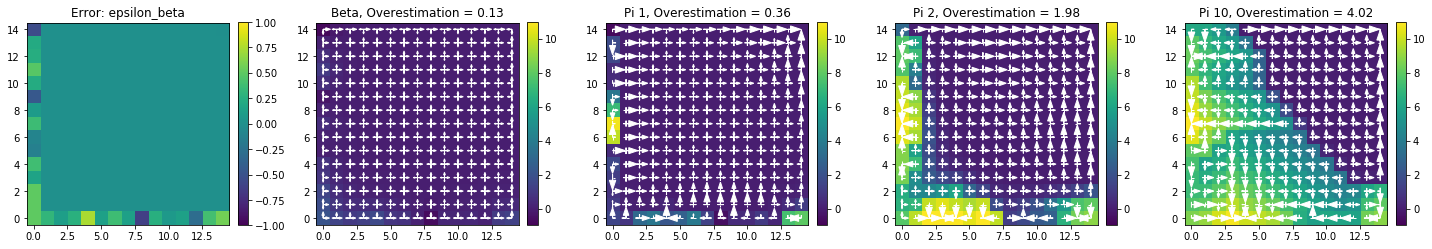

In [33]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 4)

im = render_Q_ax(ax[0], error_grid.reward_array, beta, show_actions=False, vmin=-1, vmax=1)
ax[0].set_title('Error: epsilon_beta')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

init_Q = error_grid.reward_array
Q = value_estimation(error_grid, beta, init_Q, iters=100, gamma=discount)
#Q_true = value_estimation(grid, beta, grid.reward_array, iters=100, gamma=discount)

im = render_Q_ax(ax[1], Q, beta, vmin=-1, vmax=11)
ax[1].set_title('Beta, Overestimation = ' + "{:.2f}".format(get_value(Q, beta)))
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

for i in [1,2,10]:

    pi = pis[i]
    init_Q = error_grid.reward_array
    Q = value_estimation(error_grid, pi, init_Q, iters=100, gamma=discount)
    #Q_true = value_estimation(grid, pi, grid.reward_array, iters=100, gamma=discount)
    
    idx = min(i+1, 4)
    im = render_Q_ax(ax[idx], Q, pi, vmin=-1, vmax=11)
    ax[idx].set_title('Pi ' + str(i) + ', Overestimation = ' + "{:.2f}".format(get_value(Q, pi)))
    
    plt.colorbar(im, ax=ax[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('gridworld_error.png', dpi=300)
plt.show()

# Multistep good

In [34]:
x_size = 15
y_size = 15
r = np.zeros((x_size,y_size,5))
r[-1, -1, :] = 1

r[0, :, :] = -0.5
r[:, 0, :] = -0.5

sigma = np.zeros((x_size,y_size,5))
sigma[0, :, :] =  1.0
sigma[:, 0, :] =  1.0

grid = GridWorld(r,  sigma)

# uniform beta
avail = grid.avail_actions
uniform = avail / np.sum(avail, axis=2, keepdims=True)

# non-uniform beta
biased_pi = np.zeros_like(uniform)

# bad
biased_pi[1:, :, LEFT] = 0.5
biased_pi[:, 1:, DOWN] = 0.5
biased_pi[0, 1:, DOWN] = 1.0
biased_pi[1:, 0, LEFT] = 1.0
biased_pi[0, 0, STAY] = 1.0

mix = 0.2
beta = mix * biased_pi + (1.0 - mix) * uniform

np.random.seed(2)
data = collect_data(grid, beta, 100, 100)
emp_grid = empirical_mdp(data, grid)

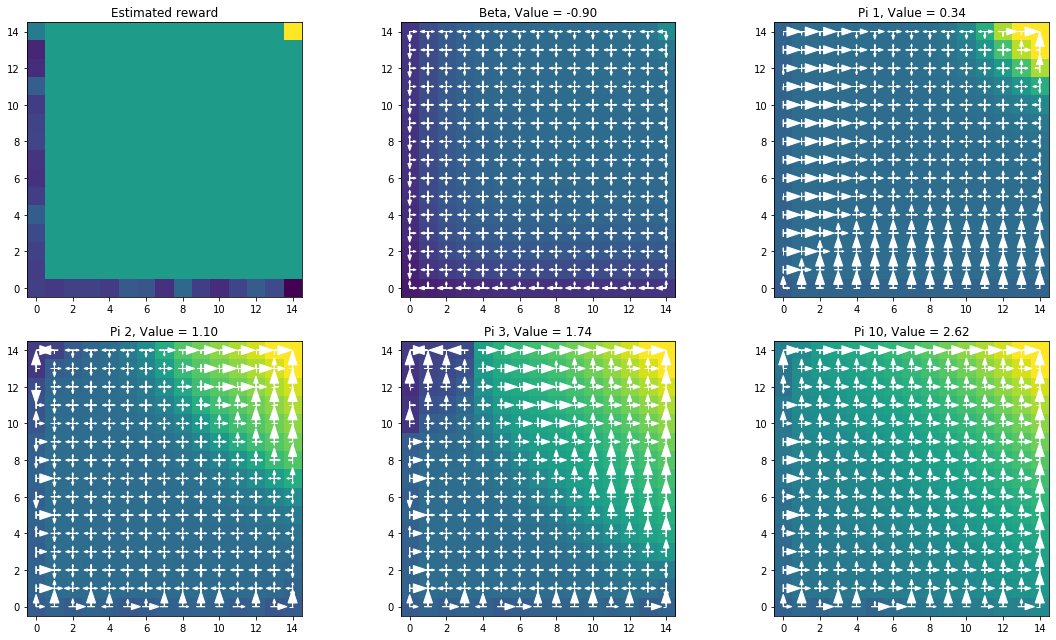

In [35]:
temp = 10.0
discount = 0.9


fig, ax = plt.subplots(2, 3)
fig.set_size_inches(16, 9)

render_Q_ax(ax[0,0], emp_grid.reward_array, beta, show_actions=False)
ax[0,0].set_title('Estimated reward')

init_Q = emp_grid.reward_array
Q = value_estimation(emp_grid, beta, init_Q, iters=100, gamma=discount)
Q_true = value_estimation(grid, beta, grid.reward_array, iters=100, gamma=discount)

render_Q_ax(ax[0,1], Q_true, beta, vmin=-5, vmax=9)
ax[0,1].set_title('Beta, Value = ' + "{:.2f}".format(get_value(Q_true, beta)))

pis = [beta]

for i in range(1,11):

    pi = get_exp_policy(beta, Q, temp)
    pis.append(pi)
    init_Q = emp_grid.reward_array
    Q = value_estimation(emp_grid, pi, init_Q, iters=100, gamma=discount)
    Q_true = value_estimation(grid, pi, grid.reward_array, iters=100, gamma=discount)
    
    if i == 1:
        render_Q_ax(ax[0,2], Q_true, pi, vmin=-5, vmax=9)
        ax[0,2].set_title('Pi ' + str(i) + ', Value = ' + "{:.2f}".format(get_value(Q_true, pi)))
    
    elif i <= 3 or i == 10:
        idx = min(i-2, 2)
        render_Q_ax(ax[1,idx], Q_true, pi, vmin=-5, vmax=9)
        ax[1,idx].set_title('Pi ' + str(i) + ', Value = ' + "{:.2f}".format(get_value(Q_true, pi)))
        
plt.tight_layout()
plt.savefig('gridworld_multistep.png', dpi=300)
plt.show()

In [36]:
error_grid = GridWorld(emp_grid.reward_array - grid.reward_array)

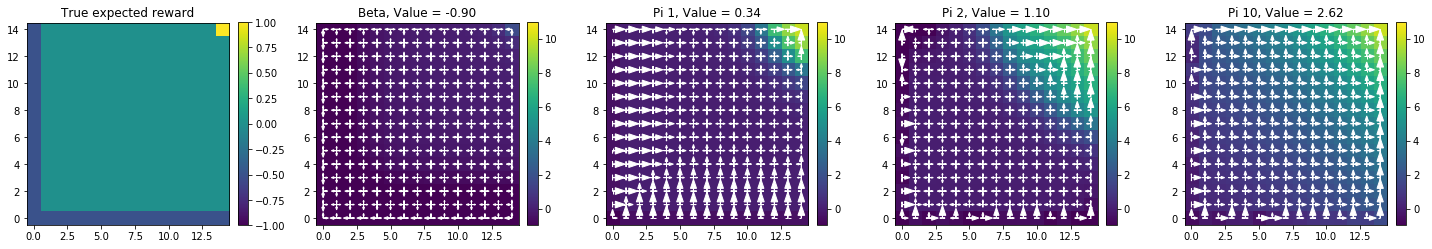

In [37]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 4)

im = render_Q_ax(ax[0], grid.reward_array, beta, show_actions=False, vmin=-1, vmax=1)
ax[0].set_title('True expected reward')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

init_Q = error_grid.reward_array
#Q = value_estimation(error_grid, beta, init_Q, iters=100, gamma=discount)
Q_true = value_estimation(grid, beta, grid.reward_array, iters=100, gamma=discount)

im = render_Q_ax(ax[1], Q_true, beta, vmin=-1, vmax=11)
ax[1].set_title('Beta, Value = ' + "{:.2f}".format(get_value(Q_true, beta)))
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

for i in [1,2,10]:

    pi = pis[i]
    init_Q = grid.reward_array
    #Q = value_estimation(error_grid, pi, init_Q, iters=100, gamma=discount)
    Q_true = value_estimation(grid, pi, grid.reward_array, iters=100, gamma=discount)
    
    idx = min(i+1, 4)
    im = render_Q_ax(ax[idx], Q_true, pi, vmin=-1, vmax=11)
    ax[idx].set_title('Pi ' + str(i) + ', Value = ' + "{:.2f}".format(get_value(Q_true, pi)))
    
    plt.colorbar(im, ax=ax[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('multi_gridworld_flat.png', dpi=300)
plt.show()

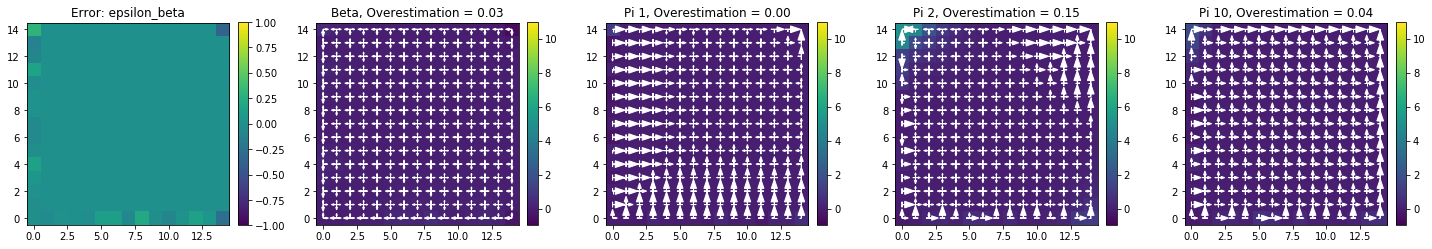

In [38]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20, 4)

im = render_Q_ax(ax[0], error_grid.reward_array, beta, show_actions=False, vmin=-1, vmax=1)
ax[0].set_title('Error: epsilon_beta')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

init_Q = error_grid.reward_array
Q = value_estimation(error_grid, beta, init_Q, iters=100, gamma=discount)
#Q_true = value_estimation(grid, beta, grid.reward_array, iters=100, gamma=discount)

im = render_Q_ax(ax[1], Q, beta, vmin=-1, vmax=11)
ax[1].set_title('Beta, Overestimation = ' + "{:.2f}".format(get_value(Q, beta)))
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

for i in [1,2,10]:

    pi = pis[i]
    init_Q = error_grid.reward_array
    Q = value_estimation(error_grid, pi, init_Q, iters=100, gamma=discount)
    #Q_true = value_estimation(grid, pi, grid.reward_array, iters=100, gamma=discount)
    
    idx = min(i+1, 4)
    im = render_Q_ax(ax[idx], Q, pi, vmin=-1, vmax=11)
    ax[idx].set_title('Pi ' + str(i) + ', Overestimation = ' + "{:.2f}".format(get_value(Q, pi)))
    
    plt.colorbar(im, ax=ax[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('multi_gridworld_error.png', dpi=300)
plt.show()

# Simple navigation

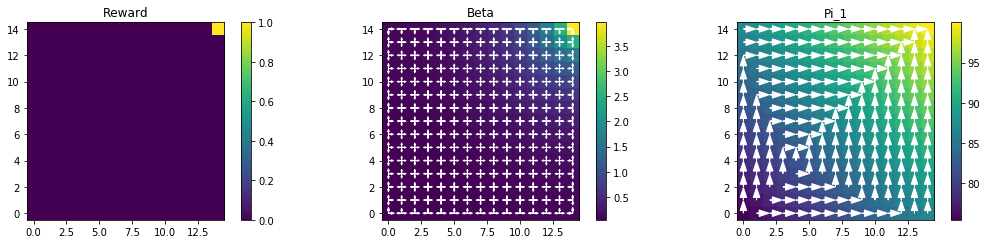

In [61]:
x_size = 15
y_size = 15
r = np.zeros((x_size,y_size,5))
r[-1, -1, :] = 1
grid = GridWorld(r)

# uniform pi
pi = grid.avail_actions / np.sum(grid.avail_actions, axis=2, keepdims=True)

init_Q = r



fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 3.5)


render_Q_ax(ax[0], grid.reward_array, pi, show_actions=False)
ax[0].set_title('Reward')

# run value estimation
Q = value_estimation(grid, pi, init_Q, iters=1000, gamma=0.99)

render_Q_ax(ax[1], Q, pi, ) # vmin=0, vmax=10
ax[1].set_title('Beta')


# get greedy policy
pi_greedy = get_greedy_policy(Q, grid.avail_actions)

# run value estimation
Q_greedy = value_estimation(grid, pi_greedy, init_Q, iters=1000, gamma=0.99)

render_Q_ax(ax[2], Q_greedy, pi_greedy, ) # vmin=0, vmax=10
ax[2].set_title('Pi_1')

plt.tight_layout()
plt.savefig('optimal_grid.png', dpi=400)
plt.show()

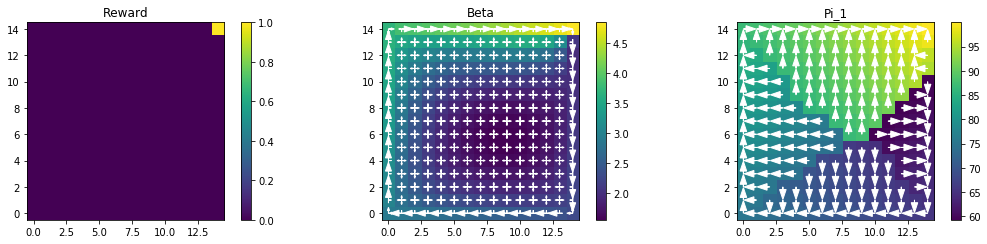

In [62]:
x_size = 15
y_size = 15
r = np.zeros((x_size,y_size,5))
r[-1, -1, :] = 1
grid = GridWorld(r)

# uniform pi
pi = grid.avail_actions / np.sum(grid.avail_actions, axis=2, keepdims=True)
 
pi[0, 1:-1, :] *= 0.03 / 0.25
pi[0, 1:-1, UP] = 0.91

pi[-1, 1:-1, :] *= 0.03 / 0.25
pi[-1, 1:-1, DOWN] = 0.91 

pi[1:-1, -1, :] *= 0.03 / 0.25
pi[1:-1, -1, RIGHT] = 0.91 

pi[1:-1, 0, :] *= 0.03 / 0.25
pi[1:-1, 0, LEFT] = 0.91

init_Q = r



fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 3.5)


render_Q_ax(ax[0], grid.reward_array, pi, show_actions=False)
ax[0].set_title('Reward')

# run value estimation
Q = value_estimation(grid, pi, init_Q, iters=1000, gamma=0.99)

render_Q_ax(ax[1], Q, pi, ) # vmin=0, vmax=10
ax[1].set_title('Beta')


# get greedy policy
pi_greedy = get_greedy_policy(Q, grid.avail_actions)

# run value estimation
Q_greedy = value_estimation(grid, pi_greedy, init_Q, iters=1000, gamma=0.99)

render_Q_ax(ax[2], Q_greedy, pi_greedy, ) # vmin=0, vmax=10
ax[2].set_title('Pi_1')

plt.tight_layout()
plt.savefig('sub_optimal_grid.png', dpi=400)
plt.show()

# Lava walk

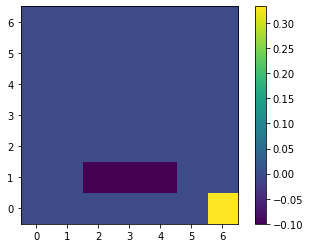

reward


In [55]:
x_size = 7
y_size = 7
r = np.zeros((x_size,y_size,5))
r[-1, 0, STAY] = 1
r[2:-2, 1, :] = -0.1
grid = GridWorld(r)

grid.render()
print('reward')

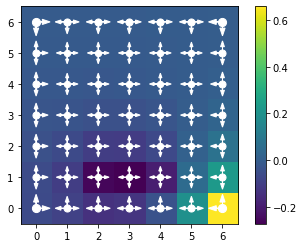

behavior value at [0,0]:  -0.06416981068394924


In [56]:
# uniform pi
pi = grid.avail_actions / np.sum(grid.avail_actions, axis=2, keepdims=True)
init_Q = r

# run value estimation
Q = value_estimation(grid, pi, init_Q, iters=100, gamma=0.9)

render_Q(Q, pi, show_greedy=False, show_all_actions=True)

print('behavior value at [0,0]: ', np.sum(pi * Q, axis=2)[0,0])

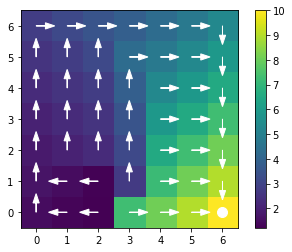

greedy value at [0,0]:  1.5009463529699911


In [57]:
# get greedy policy
pi_greedy = get_greedy_policy(Q, grid.avail_actions)

# run value estimation
Q_greedy = value_estimation(grid, pi_greedy, init_Q, iters=1000, gamma=0.9)

render_Q(Q_greedy, pi_greedy)

print('greedy value at [0,0]: ', np.sum(pi_greedy * Q_greedy, axis=2)[0,0])

# Non-uniform lava

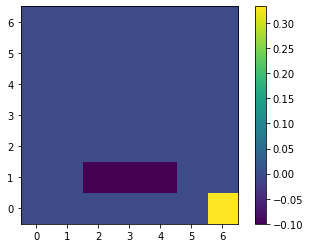

reward


In [58]:
x_size = 7
y_size = 7
r = np.zeros((x_size,y_size,5))
r[-1, 0, STAY] = 1
r[2:-2, 1, :] = -0.1
grid = GridWorld(r)

grid.render()
print('reward')

In [62]:
# non-uniform pi
avail = grid.avail_actions
pi = avail / np.sum(avail, axis=2, keepdims=True)

pi[2:-2,0, UP] = 0.0
pi[2:-2,0, RIGHT] = 0.5

pi[2:-2,2, DOWN] = 0.0
pi[2:-2,2, RIGHT] = 0.4

pi[1,1, DOWN] = 0.3
pi[1,1, RIGHT] = 0.1

pi[-2,1, DOWN] = 0.3
pi[-2,1, LEFT] = 0.1

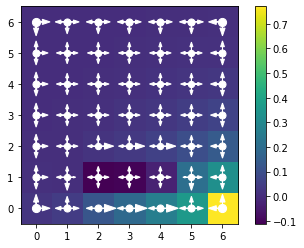

behavior value at [0,0]:  0.023777977936046447


In [63]:
# run value estimation
init_Q = r
Q = value_estimation(grid, pi, init_Q, iters=100, gamma=0.9)
render_Q(Q, pi, show_greedy=False, show_all_actions=True)

print('behavior value at [0,0]: ', np.sum(pi * Q, axis=2)[0,0])

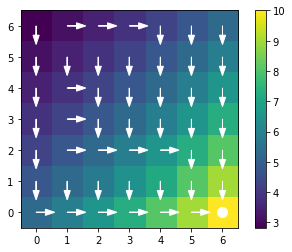

greedy value at [0,0]:  5.314409999999998


In [64]:
# get greedy policy
pi_greedy = get_greedy_policy(Q, grid.avail_actions)

# run value estimation
Q_greedy = value_estimation(grid, pi_greedy, init_Q, iters=1000, gamma=0.9)

render_Q(Q_greedy, pi_greedy)

print('greedy value at [0,0]: ', np.sum(pi_greedy * Q_greedy, axis=2)[0,0])